In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot

┌ Info: Precompiling IonSim [511e77fe-ab93-41f7-8f07-8f89809c6435]
└ @ Base loading.jl:1260


PyPlot

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

Consider two ions and a single vibrational mode, addressed by bichromatic light in a rotating frame:<br><br>

---
${\hat{H} = \frac{\Omega(t)}{2} \sum\limits_{i=1,2}\bigg[ \bigg(\hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)}\bigg) \otimes e^{i[\eta (\hat{a}e^{-i\nu t} + \hat{a}^{\dagger}e^{i\nu t}) - (\Delta_i t + \phi_i)]} \bigg] + h.c. }
$

---

Assuming $\Delta_i = \pm (\nu + \epsilon)$, then under the right conditions, this interaction (known as a Molmer-Sorensen interaction) can be used to produce a maximally entangled Bell state of the two ions. 

However, it is [shown](https://iopscience.iop.org/article/10.1088/1367-2630/10/1/013002/meta) that a poor choice of the relative phase $\Delta\phi = \phi_1 - \phi_2$ between the two lasers, can impact the quality of this process by amplifying the effect of off-resonant carrier transitions.

Fortunately, by ramping up the amplitudes of the lasers, we can eliminate this dependency on $\Delta\phi$.

In this example, we examine this effect, which will demonstrate how to apply time-dependent laser amplitudes.

# First take $\Delta\phi=0$

In [81]:
# Construct the system
C = ca40(selected_level_structure=["S-1/2", "D-1/2"])
L1 = laser(); L1.pointing = [(1, 1.0), (2, 1.0)]
L2 = laser(); L2.pointing = [(1, 1.0), (2, 1.0)]
chain = linearchain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=2.5e5), selected_modes=(x=[], y=[], z=[1]))
T = trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/ion_configurations.jl:161


In [82]:
mode = T.configuration.vibrational_modes.z[1]

# Set the laser parameters
ϵ = 10e3
d = 350  # corrects for AC stark shift from single-photon coupling to sidebands
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L1.Δ = Δf + mode.ν + ϵ - d
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - mode.ν - ϵ + d
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(mode, L1, C))
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ
Efield_from_pi_time!(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_pi_time!(pi_time, T, 2, 1, ("S-1/2", "D-1/2"));

In [83]:
# Set the dimension of the vibrational mode
mode.N = 10;

In [84]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);  # setup the Hamiltonian

In [85]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ion_state(T, "S-1/2", "S-1/2") ⊗ fockstate(mode.basis, 0), h);

  0.072197 seconds (635.10 k allocations: 33.032 MiB)


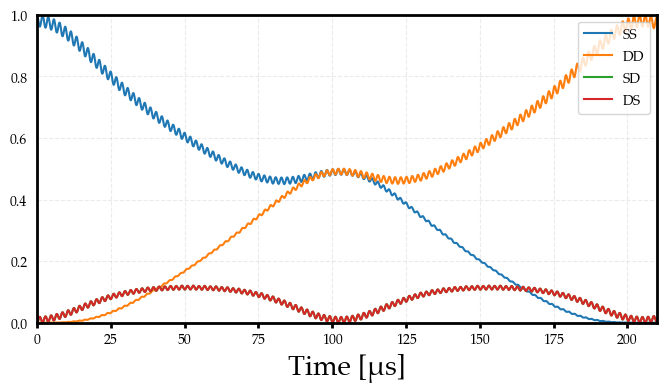

In [86]:
SS = expect(ion_projector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ion_projector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ion_projector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ion_projector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

# Now take $\Delta\phi = \pi/2$

In [111]:
L1.ϕ = t -> π;

In [112]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [113]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ion_state(T, "S-1/2", "S-1/2") ⊗ fockstate(mode.basis, 0), h);

  0.078515 seconds (700.76 k allocations: 36.288 MiB)


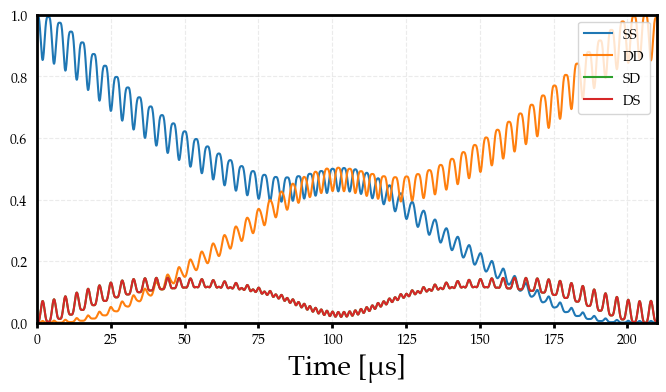

In [114]:
SS = expect(ion_projector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ion_projector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ion_projector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ion_projector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

# Keeping $\Delta\phi=\pi/2$, apply ramps to the laser amplitudes

In [62]:
E = Efield_from_pi_time(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))

# Simple amplitude ramping function
function Ω(t)
    if t < 20
        return E * sin(2π * t / 80)^2
    elseif t > 200
        return E * cos(2π * (t - 200) / 80)^2
    else
        E
    end
end;

In [63]:
L1.E = t -> Ω(t)
L2.E = t -> Ω(t);

In [64]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [67]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:220, ion_state(T, "S-1/2", "S-1/2") ⊗ fockstate(mode.basis, 0), h);

  0.126015 seconds (2.02 M allocations: 64.116 MiB)


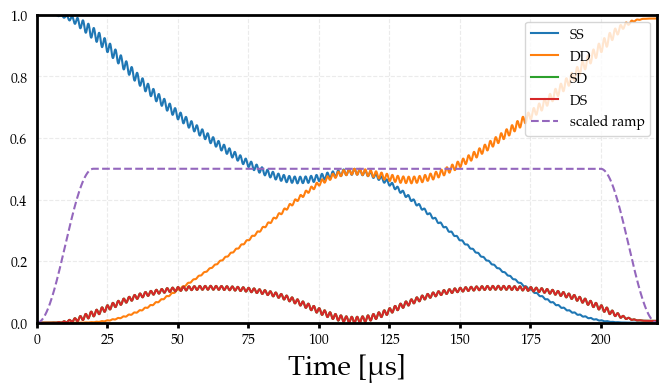

In [68]:
SS = expect(ion_projector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ion_projector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ion_projector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ion_projector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");